In [1]:
import torch
import torchvision
from diffusers import UNet2DModel
from pipeline_ddpm_custom import DDPMPipelineCustom
from scheduling_rectflow import RectFlowScheduler, RectFlowInverseScheduler
import matplotlib.pyplot as plt
import os
from PIL import Image
import torchvision.transforms.functional as F
from IPython.display import HTML
from base64 import b64encode

def show_video(video_path):
    video_file = open(video_path, "r+b").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video width="128" height="128" autoplay loop><source src="{video_url}"></video>""")

# Load the trained model and scheduler
model_dir = "./output/cls_cnd_aug_printed//"
unet = UNet2DModel.from_pretrained(f"{model_dir}/unet")
scheduler_config_path = os.path.join(model_dir, "scheduler", "scheduler_config.json")
scheduler = RectFlowScheduler.from_config(scheduler_config_path)
scheduler_inv = RectFlowInverseScheduler.from_config(scheduler_config_path)
if torch.cuda.is_available():
    unet.to('cuda')

/data/schu23/mldl/project/Handwriting-Beautification/diffusers/src/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'scheduling_rectflow.RectFlowScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)
/data/schu23/mldl/project/Handwriting-Beautification/diffusers/src/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'scheduling_rectflow.RectFlowInverseScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-pas

In [2]:
import math
def lerp(z1, z2, alpha):
    return (1 - alpha) * z1 + alpha * z2
def slerp(z1, z2, alpha):
    theta = torch.acos(torch.sum(z1 * z2) / (torch.norm(z1) * torch.norm(z2)))
    return (
        torch.sin((1 - alpha) * theta) / torch.sin(theta) * z1
        + torch.sin(alpha * theta) / torch.sin(theta) * z2
    )

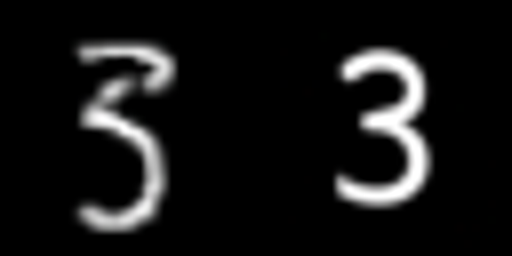

In [3]:
num_inverse_step = 200
num_denoise_step = 50
label = 3
handwrite_img = Image.open('interpolate_samples/handwriting/3/2.png').resize((32, 32))
printed_img = Image.open('interpolate_samples/printed/3/0.png').resize((32, 32))
cmb_img = Image.new('RGB', (64, 32))
cmb_img.paste(handwrite_img, (0 ,0))
cmb_img.paste(printed_img, (32 ,0))
cmb_img.resize((512, 256))

In [4]:
# Create the pipeline
pipeline = DDPMPipelineCustom(
    unet=unet,
    scheduler=scheduler,
)
pipeline_inv = DDPMPipelineCustom(
    unet=unet,
    scheduler=scheduler_inv,
)
class_conditioning = unet.class_embedding is not None
def get_label_tensor(size):
    return torch.tensor([label] * size, device=unet.device) if class_conditioning else None

In [5]:
# Run noise inversion on the given images
images = torch.stack([F.to_tensor(handwrite_img), F.to_tensor(printed_img)]) * 2 - 1
semantic_noise = pipeline_inv(get_label_tensor(2), init_noise=images, clamp_output=False, num_inference_steps=num_inverse_step, output_type='pt').images

  0%|          | 0/200 [00:00<?, ?it/s]

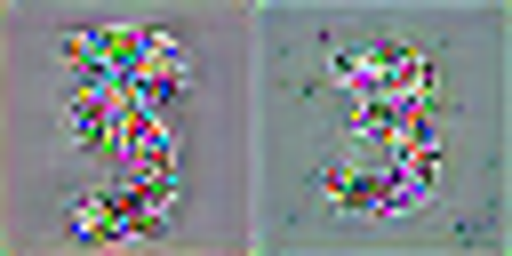

In [6]:
F.to_pil_image(torch.cat([n for n in semantic_noise], dim=-1)).resize((512, 256))

In [7]:
# test reconstruction
images = pipeline(get_label_tensor(2), init_noise=semantic_noise * 2 - 1, num_inference_steps=num_denoise_step, output_type='pt').images

  0%|          | 0/50 [00:00<?, ?it/s]

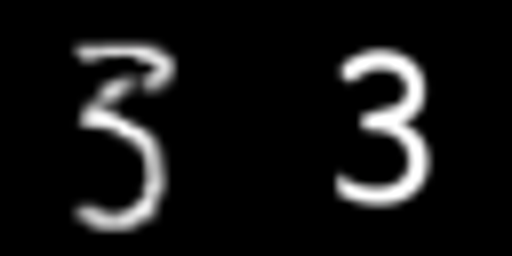

In [8]:
F.to_pil_image(torch.cat([i for i in images], dim=-1)).resize((512, 256))

In [32]:
# interpolation
interpolant = []
interpolant.append(semantic_noise[0])
for i in range(1, 10):
    interpolant.append(lerp(
        semantic_noise[0],
        semantic_noise[1],
        i / 10,
    ))
interpolant.append(semantic_noise[1])
interpolant = torch.stack(interpolant)

results = pipeline(get_label_tensor(len(interpolant)), init_noise=interpolant * 2 - 1, num_inference_steps=num_denoise_step, output_type='pt').images

  0%|          | 0/50 [00:00<?, ?it/s]

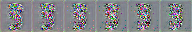

In [33]:
F.to_pil_image(torch.cat([i for i in interpolant], dim=-1))#.resize((64 * results.size(0), 64))

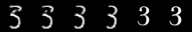

In [34]:
F.to_pil_image(torch.cat([i for i in results], dim=-1))#.resize((64 * results.size(0), 64))

In [12]:
torchvision.io.write_video(
    '/tmp/tt.mp4',
    results.permute(0, 2, 3, 1) * 255,
    4,
    options={'crf': '18'})
show_video('/tmp/tt.mp4')

In [27]:
# now, increase the sample rate
terminal = 0.36
interpolant = []
sr = 90
for i in torch.linspace(0, terminal, sr):
    interpolant.append(lerp(
        semantic_noise[0],
        semantic_noise[1],
        i,
    ))
interpolant = torch.stack(interpolant)

results = pipeline(get_label_tensor(len(interpolant)), init_noise=interpolant * 2 - 1, num_inference_steps=num_denoise_step, output_type='pt').images

  0%|          | 0/50 [00:00<?, ?it/s]

In [28]:
torchvision.io.write_video(
    '/tmp/tt.mp4',
    results.permute(0, 2, 3, 1) * 255,
    int(sr / 3), # transition in 2s
    options={'crf': '18'})
show_video('/tmp/tt.mp4')